<a href="https://colab.research.google.com/github/Aniket7773/CreditCardFraud/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb


In [41]:
data_path = '/content/drive/MyDrive/Colab Notebooks/german_credit_data.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

# Drop index column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Convert relevant columns to categorical
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')



--- Data Overview ---
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car  

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 n

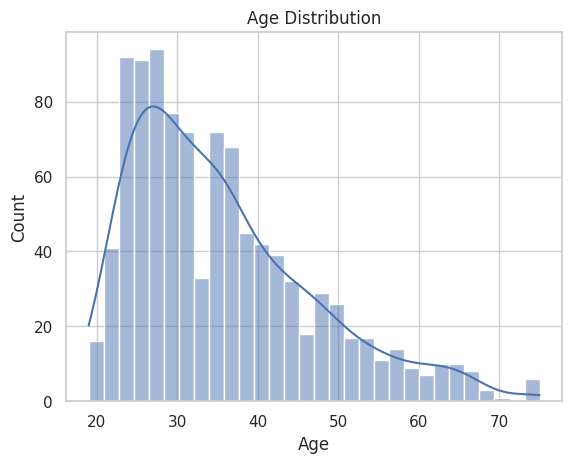

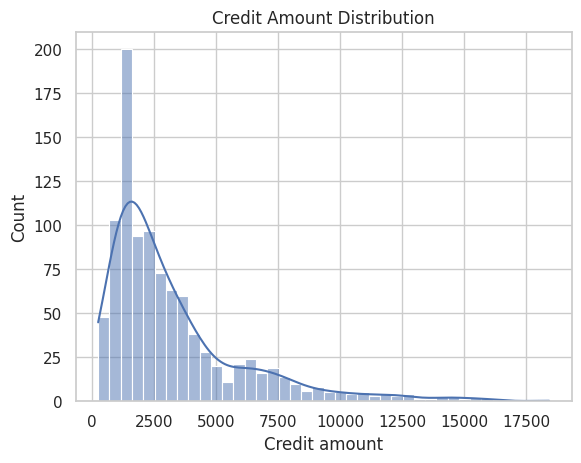

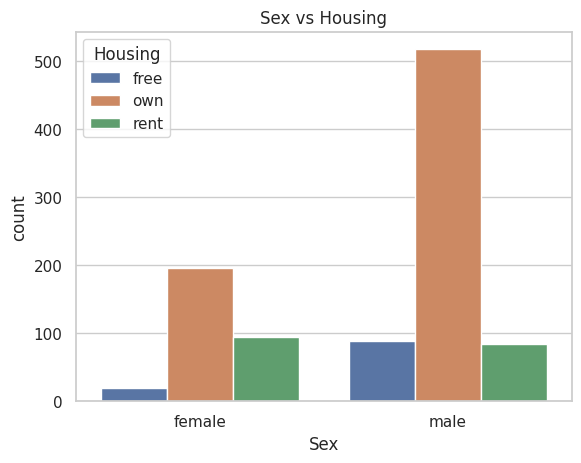

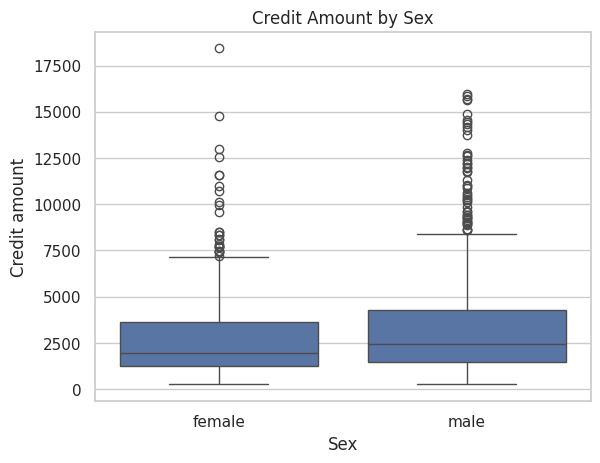

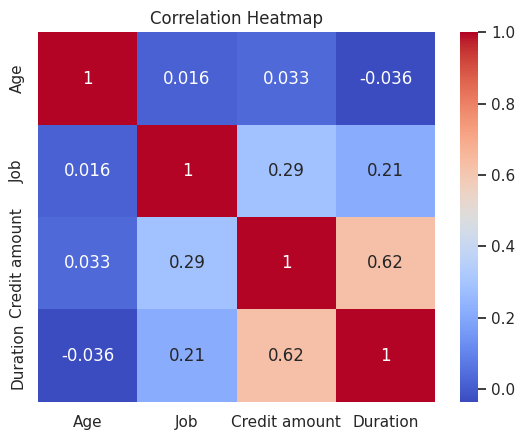

In [42]:
print('\n--- Data Overview ---')
print(df.head())

print('\n--- Info ---')
print(df.info())

print('\n--- Summary Statistics ---')
print(df.describe(include='all'))

print('\n--- Missing Values ---')
print(df.isnull().sum())

# Visualizations
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['Credit amount'], bins=40, kde=True)
plt.title('Credit Amount Distribution')
plt.show()

sns.countplot(data=df, x='Sex', hue='Housing')
plt.title('Sex vs Housing')
plt.show()

sns.boxplot(x='Sex', y='Credit amount', data=df)
plt.title('Credit Amount by Sex')
plt.show()

sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [50]:
# -------------------------------
# 🧹 Data Cleaning & Imputation
# -------------------------------

# Convert object-type columns to category if needed
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# Handle missing values
for col in df.columns:
    if df[col].dtype.name == 'category':
        if 'Unknown' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('Unknown')
        df[col] = df[col].fillna('Unknown')
    elif df[col].dtype.name in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())

# Remove duplicate rows
initial_shape = df.shape
df.drop_duplicates(inplace=True)
if df.shape != initial_shape:
    print(f"🧽 Removed {initial_shape[0] - df.shape[0]} duplicate rows.")

# Remove rows with invalid values
df = df[df['Age'] > 0]  # Valid age
df = df[df['Duration'] > 0]  # Valid duration
df = df[df['Credit amount'] > 0]  # Valid credit amount

# Reset index
df.reset_index(drop=True, inplace=True)

print("\n✅ Data cleaning completed. Cleaned data preview:")
print(df.head())



✅ Data cleaning completed. Cleaned data preview:
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own         Unknown           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little          Unknown           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  HighCredit  Credit_per_Month  
0         6             radio/TV           0        194.833333  
1        48             radio/TV           1        123.979167  
2        12            education           0        174.666667  
3        42  furniture/equipment           1        187.666667  
4        24                  car           1        202.916667  


In [62]:
# Binary target based on median credit amount
median_credit = df['Credit amount'].median()
df['HighCredit'] = (df['Credit amount'] > median_credit).astype(int)

# New Feature: Credit-per-Month
df['Credit_per_Month'] = df['Credit amount'] / df['Duration']
df['Credit_per_Month'].replace([np.inf, -np.inf], 0, inplace=True)
df['Credit_per_Month'] = df['Credit_per_Month'].fillna(0)

# Additional Engineered Features

# Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[18, 25, 35, 50, 65, 100], labels=False)

# Duration × Age interaction
df['Duration_x_Age'] = df['Duration'] * df['Age']

# Purpose frequency encoding
df['Purpose_Count'] = df.groupby('Purpose')['Purpose'].transform('count')

# Updated feature list with extras
features = features + ['Age_Group', 'Duration_x_Age', 'Purpose_Count','Credit_per_Month']


# 6. Credit-to-Income Ratio (if applicable)
# df['Credit_to_Income_Ratio'] = df['Credit amount'] / (df['Personal Income'] + 1)

# Feature selection (add new features here)


X = df[features]
y = df['HighCredit']

# One-hot encoding for categorical features
X = pd.get_dummies(X, drop_first=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [63]:
features = ['Age', 'Job', 'Duration', 'Credit_per_Month', 'Sex', 'Housing',
            'Saving accounts', 'Checking account', 'Purpose']
X = df[features]
y = df['HighCredit']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [64]:
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    scale_pos_weight=1,
    reg_alpha=0,
    reg_lambda=1
)

model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


XGBoost Prediction Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       155
           1       0.97      0.99      0.98       145

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



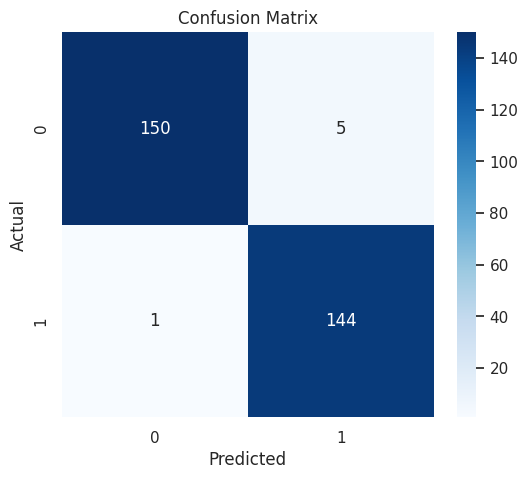

In [65]:
y_pred = model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'\nXGBoost Prediction Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### lOGISTIC REGRESSION

In [68]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
model_logreg = LogisticRegression(
    penalty='l2',            # L2 regularization
    C=1.0,                   # Inverse of regularization strength
    solver='lbfgs',          # Optimization algorithm
    max_iter=1000,           # Maximum number of iterations
    random_state=42          # Ensures reproducibility
)

# Train the model
model_logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [69]:
# Predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_logreg = model_logreg.predict(X_test)

# Evaluate
print("\n📘 Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1 Score:", f1_score(y_test, y_pred_logreg))



📘 Logistic Regression Metrics:
Accuracy: 0.9166666666666666
Precision: 0.9285714285714286
Recall: 0.896551724137931
F1 Score: 0.9122807017543859


## **RandomForestClassifier**

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
model_rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=None,        # Let trees expand fully unless specified
    min_samples_split=2,   # Minimum samples to split a node
    min_samples_leaf=1,    # Minimum samples at a leaf node
    max_features='sqrt',   # Number of features to consider at each split
    bootstrap=True,        # Use bootstrap samples
    random_state=42        # For reproducibility
)

# Train the model
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [71]:
# Predict
y_pred_rf = model_rf.predict(X_test)

# Evaluate
print("\n🌲 Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))



🌲 Random Forest Metrics:
Accuracy: 0.9433333333333334
Precision: 0.9383561643835616
Recall: 0.9448275862068966
F1 Score: 0.9415807560137457


In [72]:
# Collect metrics
models = ['XGBoost', 'Logistic Regression', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_rf)
]
precisions = [
    precision_score(y_test, y_pred),
    precision_score(y_test, y_pred_logreg),
    precision_score(y_test, y_pred_rf)
]
recalls = [
    recall_score(y_test, y_pred),
    recall_score(y_test, y_pred_logreg),
    recall_score(y_test, y_pred_rf)
]
f1_scores = [
    f1_score(y_test, y_pred),
    f1_score(y_test, y_pred_logreg),
    f1_score(y_test, y_pred_rf)
]


In [60]:
# Create DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})


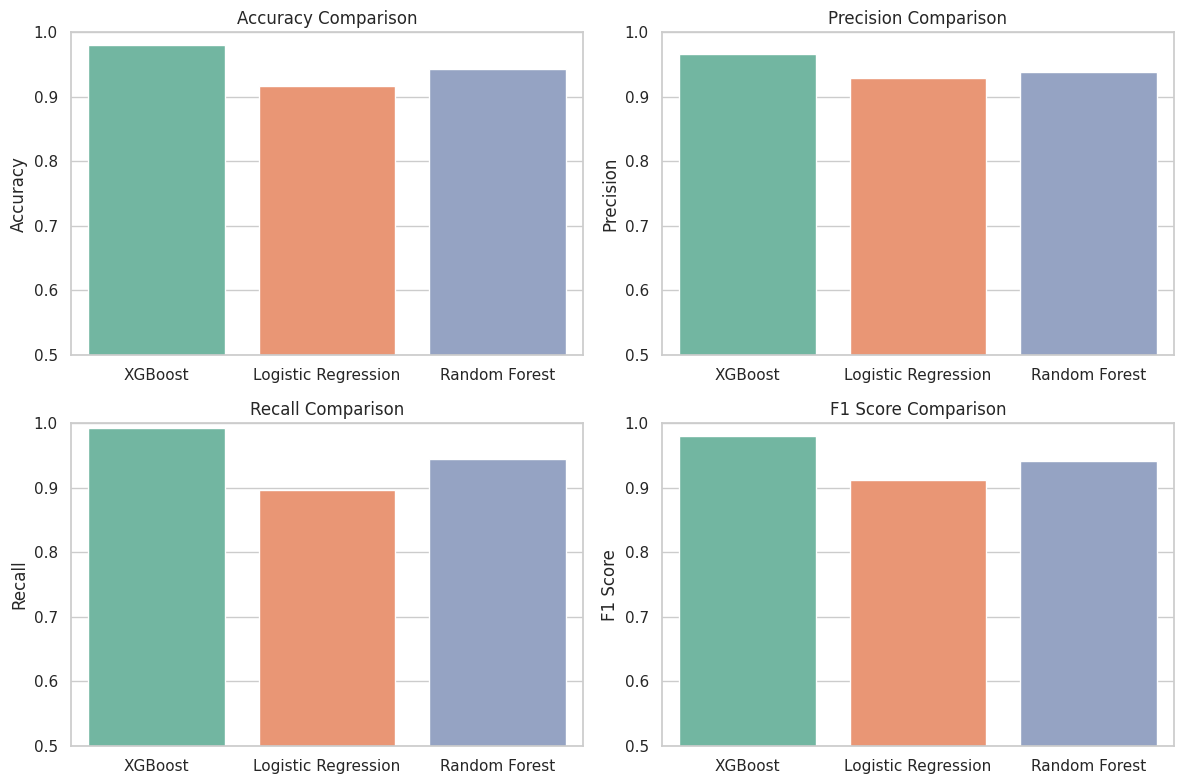

In [61]:
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=comparison_df, x='Model', y=metric, palette='Set2')
    plt.title(f'{metric} Comparison')
    plt.ylim(0.5, 1.0)  # Adjust as needed
    plt.ylabel(metric)
    plt.xlabel('')

plt.tight_layout()
plt.show()
